In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_excel("Online Retail.xlsx")
print(f"dataset: {dataset.shape}")


dataset: (541909, 8)


In [3]:
dataset.head()

# invoiceNo:주문 번호/ StockCode: 제품 코드/ Description: 제품 설명
# Quantity: 주문된 제품의 수량/ InvoiceDate: 주문 날짜/ UnitPrice: 제품의 단가
# CustomerID: 고객 식별 번호/ Country: 고객이 속한 국가

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
dataset.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## 결측치 처리

- RFM 데이터 가공해야하는데.. -> 고객의 구매 패턴
- Recency: 고객이 마지막으로 구매한 날짜에서 분석 기준 날짜를 뺀 값. 최신 거래일로부터 일수를 계산.
- Frequency: 고객의 총 구매 횟수.
- Monetary: 고객이 지출한 총 금액.

In [5]:
# 주문 고객 국가 영국 데이터만 필터링
dataset = dataset[dataset["Country"] == "United Kingdom"]

In [6]:
dataset.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [7]:
dataset = dataset.dropna(subset=["CustomerID"])

# dataset = dataset.dropna(subset=["Description"])
#RFM 데이터 가공하는데 있어서 Description은 관련이 적다.
# : 고객의 구매 패턴과는 영향이 적음. 

## RFM처리

In [8]:
dataset["TotalPrice"] = dataset["Quantity"] * dataset["UnitPrice"]


# 고객별 데이터 요약 (RFM 변수 생성)
customer_df = dataset.groupby("CustomerID").agg({
    "InvoiceDate": "max",               # Recency
    "InvoiceNo": "nunique",              # Frequency
    "TotalPrice": "sum"                  # Monetary
}).reset_index()



# 변수 이름 변경
customer_df.rename(columns={"InvoiceDate": "Recency", "InvoiceNo": "Frequency", "TotalPrice": "Monetary"}, inplace=True)



# Recency 값 변환: 마지막 구매일로부터의 일수 계산
reference_date = customer_df["Recency"].max()
customer_df["Recency"] = (reference_date - customer_df["Recency"]).dt.days

## 이상치 처리

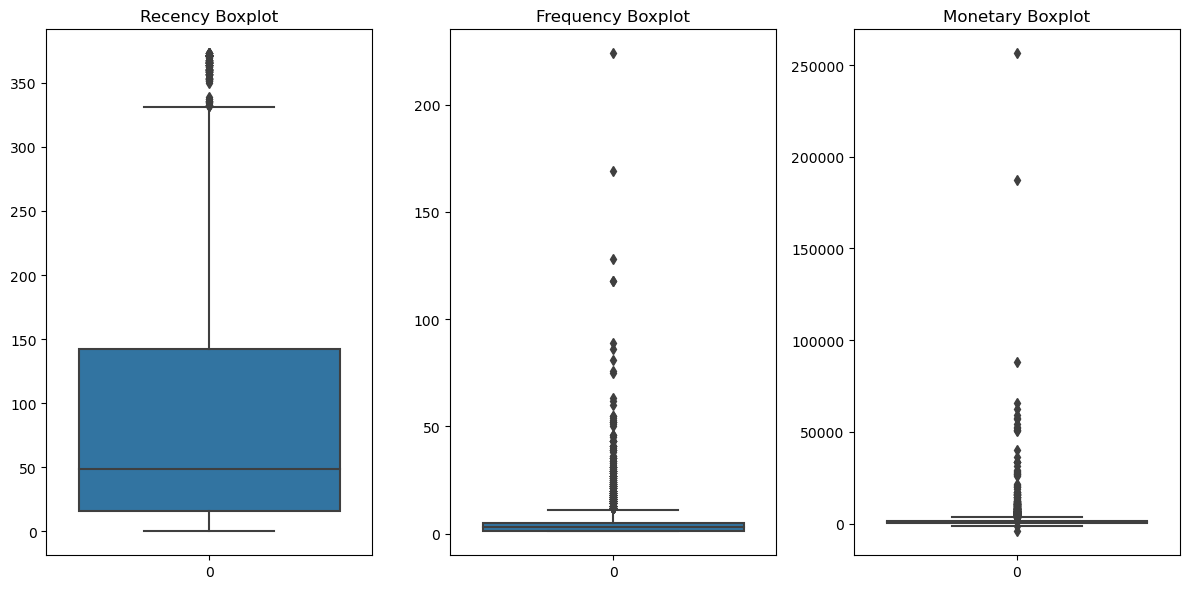

In [9]:
# Recency, Frequency, Monetary 변수에 대해 박스플롯 시각화
plt.figure(figsize=(12, 6))

# Recency 박스플롯
plt.subplot(1, 3, 1)
sns.boxplot(customer_df["Recency"])
plt.title("Recency Boxplot")

# Frequency 박스플롯
plt.subplot(1, 3, 2)
sns.boxplot(customer_df["Frequency"])
plt.title("Frequency Boxplot")

# Monetary 박스플롯
plt.subplot(1, 3, 3)
sns.boxplot(customer_df["Monetary"])
plt.title("Monetary Boxplot")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

In [10]:
# IQR 계산 함수
def calculate_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Recency, Frequency, Monetary에 대해 IQR 계산
for column in ["Recency", "Frequency", "Monetary"]:
    lower, upper = calculate_iqr(customer_df, column)
    # 하한: lower = Q1 - 1.5 * IQR
    # 상한: upper = Q3 + 1.5 * IQR
    print(f"{column} - Lower Bound: {lower}, Upper Bound: {upper}")
    
    # 이상치 확인
    outliers = customer_df[(customer_df[column] < lower) | (customer_df[column] > upper)]
    print(f"Number of outliers in {column}: {outliers.shape[0]}")
    print(outliers[[column]].head(), "\n")


Recency - Lower Bound: -173.0, Upper Bound: 331.0
Number of outliers in Recency: 130
     Recency
34       372
41       365
139      371
155      356
177      372 

Frequency - Lower Bound: -5.0, Upper Bound: 11.0
Number of outliers in Frequency: 355
    Frequency
2         224
21         16
23         26
46         12
61         36 

Monetary - Lower Bound: -1577.03625, Upper Bound: 3381.0737500000005
Number of outliers in Monetary: 384
    Monetary
1    4196.01
2   29072.10
3    3868.20
13   6748.40
21   5583.62 



Recency: 고객이 마지막으로 구매한 날짜
Frequency: 고객이 구매한 주문의 횟수
Monetary: 고객의 총 구매 금액

=> 음수가 나올 수가 없음. 음수값 제거 후 상한값을 초과한 값은 상한값으로 대체

In [12]:
# 음수값은 제거, 상한값 초과한 값은 상한값으로 수정
customer_df["Recency"] = np.where(customer_df["Recency"] < 0, np.nan, customer_df["Recency"])
upper_recency = 331
customer_df["Recency"] = np.where(customer_df["Recency"] > upper_recency, upper_recency, customer_df["Recency"])


upper_frequency = 11
customer_df["Frequency"] = np.where(customer_df["Frequency"] < 0, 0, customer_df["Frequency"])
customer_df["Frequency"] = np.where(customer_df["Frequency"] > upper_frequency, upper_frequency, customer_df["Frequency"])


upper_monetary = 3381.07
customer_df["Monetary"] = np.where(customer_df["Monetary"] > upper_monetary, upper_monetary, customer_df["Monetary"])

# 결측치 처리: IQR 처리 후 결측치 생길 수 있으므로 평균/중앙값 대체
customer_df.fillna(customer_df.mean(), inplace=True)


In [13]:
dataset.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

In [15]:
# 'customer_df'에서 'Recency', 'Frequency', 'Monetary' 열에서 0 값의 개수와 비율을 계산
zero_features = ['Recency', 'Frequency', 'Monetary']
total_count = customer_df['Recency'].count()  # customer_df로 변경
for feature in zero_features:
    zero_count = customer_df[customer_df[feature] == 0][feature].count()  # customer_df로 변경
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

# Recency: 고객이 마지막으로 구매한 날로부터의 경과 일수
# 0 이란 소리는 현재 날짜와 같기 때문일수도? -> 냅둬

# 근데 Monetary가 0인 경우는 뭐임...?

# 과감한 데이터 삭제 vs 뭔지 몰라서 그냥 냅두기: 뭐가 나을까

Recency 0 건수는 97, 퍼센트는 2.46 %
Frequency 0 건수는 0, 퍼센트는 0.00 %
Monetary 0 건수는 8, 퍼센트는 0.20 %


## 스케일링

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_df[["Recency", "Frequency", "Monetary"]])

In [17]:
#스케일링 전후 비교

# 스케일링된 데이터를 데이터프레임에 추가
scaled_df = pd.DataFrame(scaled_data, columns=["Scaled_Recency", "Scaled_Frequency", "Scaled_Monetary"])

# 원본 데이터와 스케일링된 데이터를 합친 데이터프레임
customer_df_scaled = pd.concat([customer_df, scaled_df], axis=1)

# 결과 출력
print(customer_df_scaled.head())

   CustomerID  Recency  Frequency  Monetary  Scaled_Recency  Scaled_Frequency  \
0     12346.0    325.0          2      0.00        2.408789         -0.582032   
1     12747.0      1.0         11   3381.07       -0.909323          2.159981   
2     12748.0      0.0         11   3381.07       -0.919564          2.159981   
3     12749.0      3.0          8   3381.07       -0.888841          1.245977   
4     12820.0      2.0          4    942.34       -0.899082          0.027304   

   Scaled_Monetary  
0        -1.005109  
1         2.200044  
2         2.200044  
3         2.200044  
4        -0.111799  


In [31]:
from sklearn.cluster import KMeans

# KMeans 클러스터링 수행 (클러스터 수 3)
kmeans = KMeans(n_clusters=3, random_state=42)
scaled_df['Cluster'] = kmeans.fit_predict(scaled_df[["Scaled_Recency", "Scaled_Frequency", "Scaled_Monetary"]])



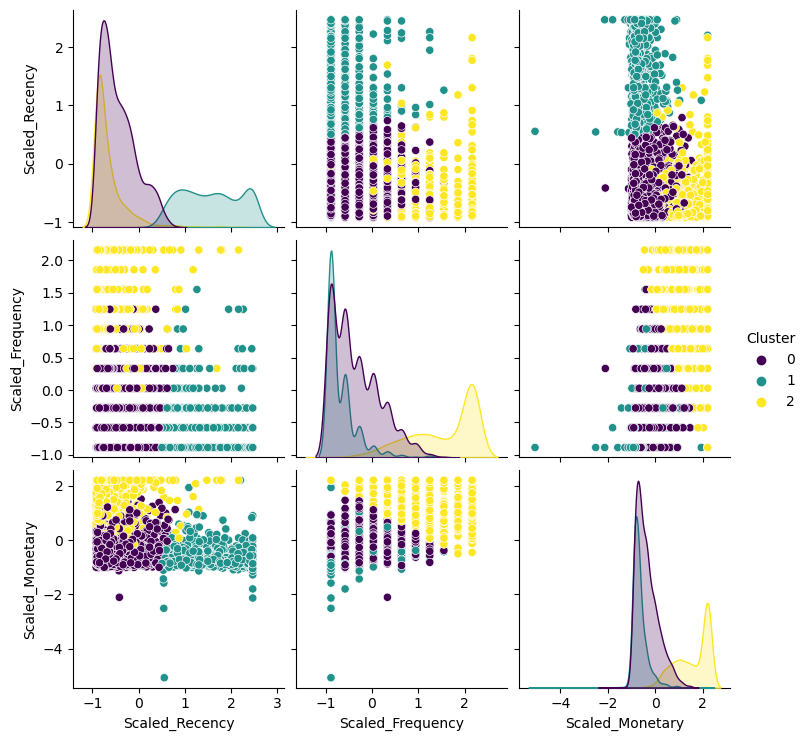

In [32]:
sns.pairplot(scaled_df, vars=["Scaled_Recency", "Scaled_Frequency", "Scaled_Monetary"], hue="Cluster", palette="viridis")
plt.show()

In [33]:
print(scaled_df.columns)


Index(['Scaled_Recency', 'Scaled_Frequency', 'Scaled_Monetary', 'Cluster'], dtype='object')


In [34]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(scaled_df[["Scaled_Recency", "Scaled_Frequency", "Scaled_Monetary"]], customer_df['Cluster'])
print(f"Silhouette Score (전체): {silhouette_avg:.2f}")

Silhouette Score (전체): 0.51


이상치 처리 안하고 Silhouette Score봤을 때 0.58이었는데 처리하니까 0.51됨    
^_________^;;; 


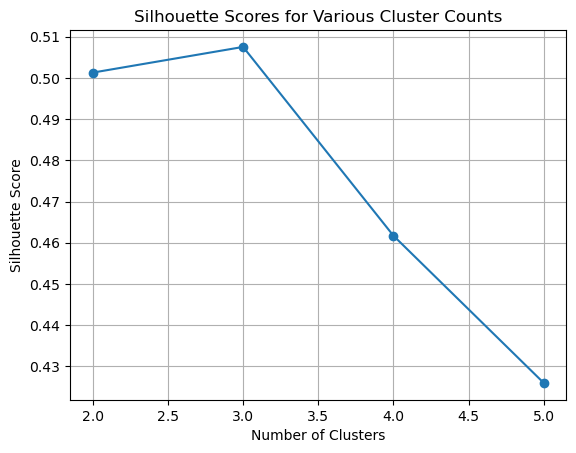

In [35]:
def visualize_silhouette(cluster_range, data):
    # 클러스터 수에 대한 실루엣 점수 계산
    silhouette_scores = []
    
    for n_clusters in cluster_range:
        # KMeans 클러스터링 수행
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        
        # 실루엣 점수 계산
        score = silhouette_score(data, cluster_labels)
        silhouette_scores.append(score)
    
    # 실루엣 점수 시각화
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Various Cluster Counts')
    plt.grid(True)
    plt.show()

# 예시로 사용할 데이터는 scaled_df의 스케일링된 피처들
X = scaled_df[["Scaled_Recency", "Scaled_Frequency", "Scaled_Monetary"]]

# 2부터 5까지의 클러스터 수에 대해 실루엣 점수 시각화
visualize_silhouette([2, 3, 4, 5], X)

순서가 조금 바뀌긴 했는데 3개로 나누는게 괜찮다.
그리고 PCA한 데이터로 함 확인해보자

## PCA

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_df)

print("PCA 결과:")
print(pca_data)

PCA 결과:
[[ 1.70973875  2.03456669]
 [-3.45083836  0.29723534]
 [-3.45445729  0.28866672]
 ...
 [ 0.63428272 -1.18765338]
 [-2.70158458  0.18946141]
 [-0.19711771 -0.72647117]]


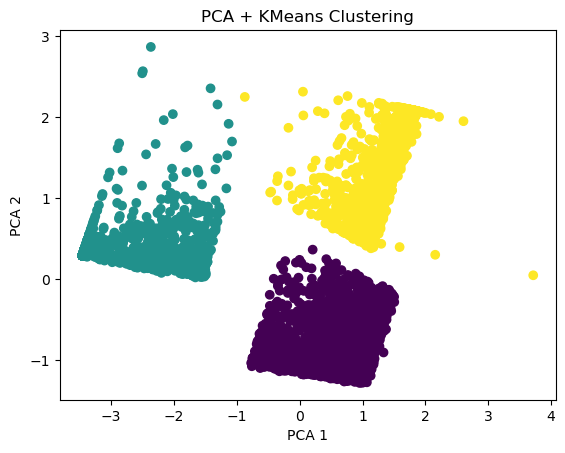

In [38]:
# K-Means 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)  # 클러스터 수는 3으로 설정
clusters = kmeans.fit_predict(pca_data)

# 결과 시각화
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis')
plt.title('PCA + KMeans Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [40]:
sil_score = silhouette_score(pca_data, kmeans.labels_)
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.660510564784589


아니


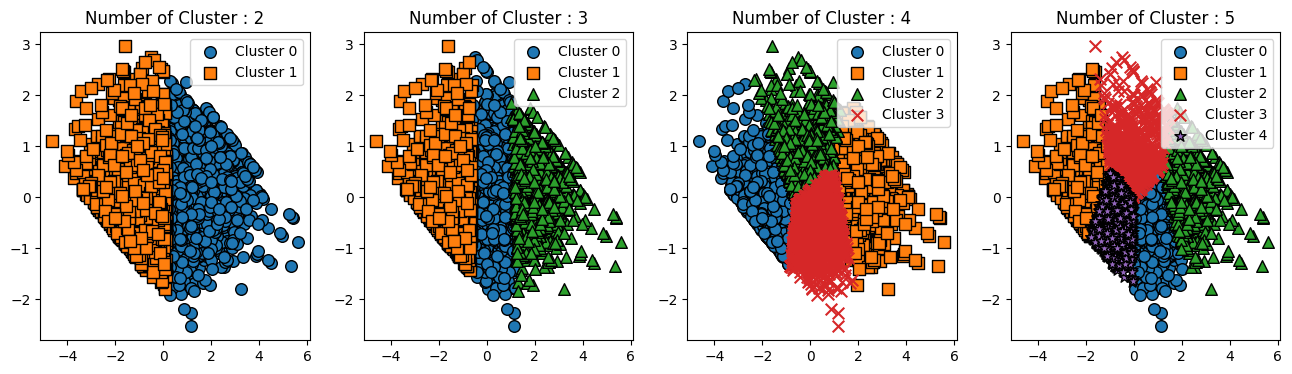


재밋네